# Статистический анализ данных аренды самокатов GoFast

# Описание данных
## users_go.csv — пользователи:
- user_id - уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)
## rides_go.csv — поездки:
- user_id - уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки
## subscriptions_go.csv —  подписки:
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

# Цель работы
Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

# План
- Шаг 1. Загрузка данных
- Шаг 2. Предобработка данных
- Шаг 3. Исследовательский анализ данных
- Шаг 4. Объединение данных
- Шаг 5. Подсчёт выручки
- Шаг 6. Проверка гипотез

# Шаг 1. Загрузка данных

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats as st
from math import factorial
from scipy.stats import binom

In [ ]:
# Загружаем данные
users = pd.read_csv("/datasets/users_go.csv")
rides = pd.read_csv("/datasets/rides_go.csv")
subs = pd.read_csv("/datasets/subscriptions_go.csv")

In [ ]:
users.info()

In [ ]:
users.head(5)

In [ ]:
rides.info()

In [ ]:
rides.head(5)

In [7]:
subs.info()

In [8]:
subs.head(5)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


# Вывод: 
Знакомство с данными не выявило серьезных отклонений или пропусков в данных. В дальнейшем приведем колонку data в датафрейме rides к типу даты pandas.

# Шаг 2. Предобработка данных

In [9]:
# Приведем столбец к нужному типу данных
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

In [10]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [11]:
rides.head(5)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [12]:
# Добавим в riders столбец с номером месяца
rides['month'] = rides['date'].dt.month

In [13]:
rides['month'].unique()

array([ 1,  4,  8, 10, 11, 12,  3,  6,  7,  2,  5,  9])

In [14]:
rides.head(5)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [15]:
# Проверяем на дубликаты
print('Число дубликатов в users:', users.duplicated().sum())
print('Число дубликатов в subs:', subs.duplicated().sum())
print('Число дубликатов в rides:', rides.duplicated().sum())

Число дубликатов в users: 31
Число дубликатов в subs: 0
Число дубликатов в rides: 0


In [16]:
len(users)

1565

In [17]:
# Удаление дубликатов в users
users = users.drop_duplicates().reset_index(drop='True')
len(users)

1534

In [18]:
# Проверяем на пропуски
print(users.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


In [19]:
print(subs.isna().sum())

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [20]:
print(rides.isna().sum())

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


# Вывод: 
Поменяли формат данных в столбце date и создали новую колонку с номером месяца поездки. Удалили дубликаты в users, проверили на пропуски.

# Шаг 3. Исследовательский анализ данных

In [21]:
#Считаем количество пользователей в городах с помощью сводной таблицы
city_pivot = users.pivot_table(index='city', values='user_id', aggfunc='count')
city_pivot_sorted = city_pivot.sort_values(by='user_id', ascending=False)
city_pivot_sorted.columns = ['users']
city_pivot_sorted

,users
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


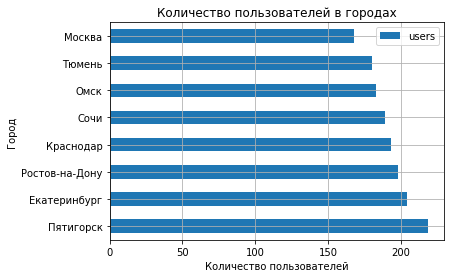

In [22]:
city_pivot_sorted.plot(kind='barh',
                       grid=True,
                       title='Количество пользователей в городах');
plt.ylabel('Город')
plt.xlabel('Количество пользователей');

Самым распространненым городом является Пятигорск, Москва же наоборот, встречается реже всего

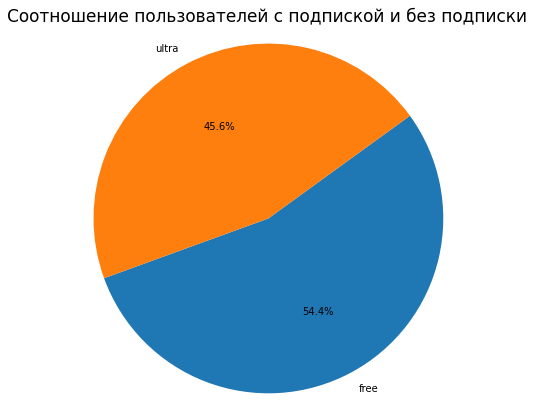

In [23]:
# Создаем счетчик значений 'subscription_type'
subscription_counts = users['subscription_type'].value_counts()

# Строим круговую диаграмму
plt.figure(figsize=(7, 7))
plt.pie(subscription_counts, labels=subscription_counts.index, autopct='%1.1f%%', startangle=200)
plt.axis('equal')
plt.title('Соотношение пользователей с подпиской и без подписки', fontsize=17)
plt.show();

Пользователей без платной подписки на 8,8% больше

In [24]:
#Средний возраст пользователей
print('Средний возраст -',users['age'].sort_values().median())

Средний возраст - 25.0


In [25]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

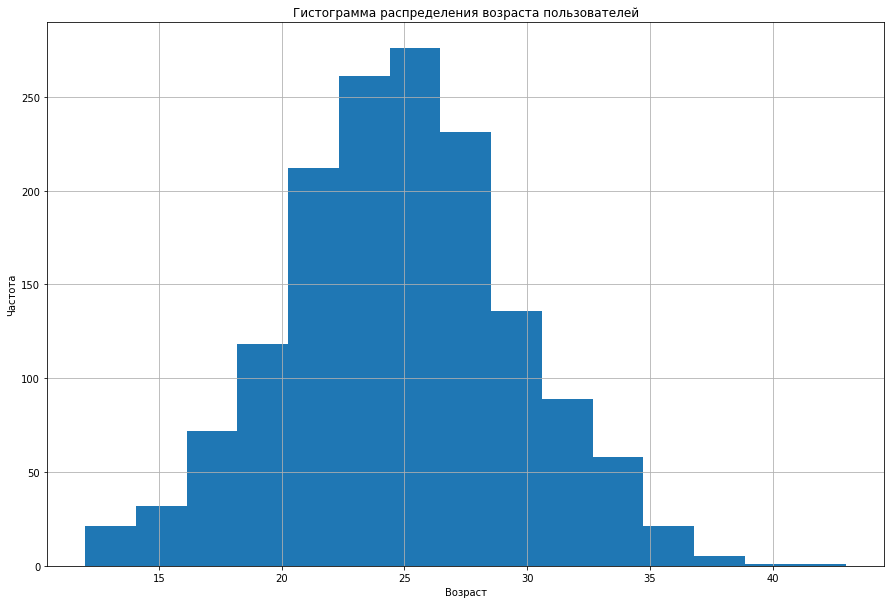

In [26]:
users.hist(column='age',
           bins = 15,
           grid=True,
           figsize = (15,10))
plt.title('Гистограмма распределения возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

Основной возраст пользователей распределен от 20 до 30 лет. Медианное значение возраста пользователей 25 лет Максимальный возраст пользователей сервиса - 43 года, минимальный - 12 лет. Особых аномалий не замечено.

In [27]:
#Среднее расстояние поездок
print('Среднее расстояние -',round(rides['distance'].sort_values().mean(),2),'метров')

Среднее расстояние - 3070.66 метров


In [28]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

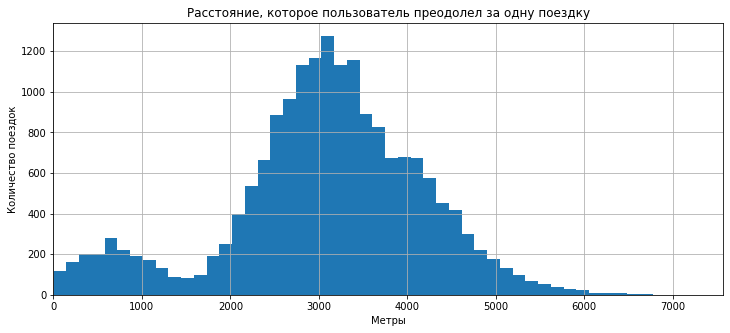

In [29]:
#Выведем график
ax = rides['distance'].plot(kind='hist', bins=50, figsize=(12,5), grid = True)
ax.set_title('Расстояние, которое пользователь преодолел за одну поездку')
ax.set_xlabel('Метры')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

Средняя поездка одного пользователя около 3000 метров , чаще всего пользователи проезжают от 2500 до 3500 метров. Максимально пользователи проезжают 7211 метров. Минимальная поездка составляет меньше метра, что может быть выбросом, но из-за небольшого количества значений лучше не удалять, кроме того, на график эти значения сильно не влияют.

In [30]:
#Среднее время поездки
print('Среднее время поездки -',round(rides['duration'].sort_values().mean(),2),'минут')

Среднее время поездки - 17.81 минут


In [31]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

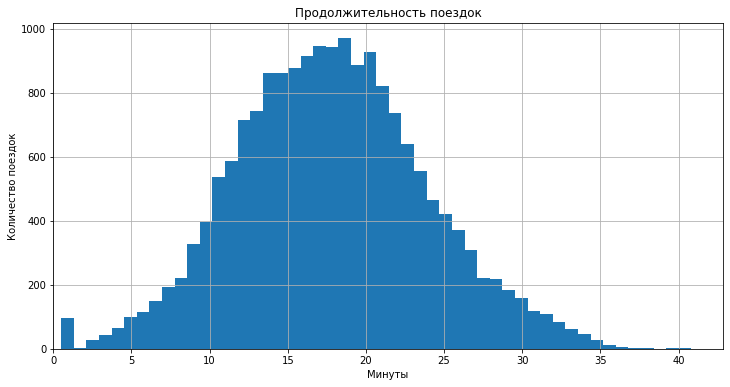

In [32]:
#Выведем график
ax = rides['duration'].plot(kind='hist', bins=50, figsize=(12,6), grid = True)
ax.set_title('Продолжительность поездок')
ax.set_xlabel('Минуты')
ax.set_ylabel('Количество поездок')
ax.set_xlim(left=0)
plt.show()

Большая часть поездок имеет продолжительность от 10 до 22 минут. Присутствует небольшое количество выбросов в диапазоне 0.5 минут и свыше 33 минут. Минимальная продолжительность поездки составляет 0.5. Максимальное значение 40.8. В среднем поездка на самокате длится около 18 минут.

In [33]:
rides.loc[rides['duration'] == 0.5].head()

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2


# Вывод: 
- Больше всего пользователей в Пятигорске, меньше всего в Москве.
- Пользователей без подписки больше на 8,8% чем пользователей с подпиской.
- Основной возраст пользователей распределен от 20 до 30 лет. Медианное значение возраста пользователей 25 лет.
- Средняя поездка одного пользователся около 3000 метров , чаще всего пользователи проезжают от 2500 до 3500 метров.
- Средняя продолжительность одной поездки 17 минут. Чаще всего продолжительность поездки лежит в диапазоне от 13 до 22 минут.
- Присутствует небольшое количество выбросов в диапазоне 0.5 минут и свыше 33 минут

# Шаг 4. Объединение данных

In [34]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


Датафрейм users состоит из 1534 строк и 5 столбцов

In [35]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


Датафрейм rides состоит из 18068 строк и 5 столбцов

In [36]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Датафрейм subs состоит из 2 строк и 4 столбцов

In [37]:
merged_table = users.merge(rides, on='user_id', how='left')
merged_table.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [38]:
merged_table = merged_table.merge(subs, on='subscription_type', how='left')
merged_table.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [39]:
merged_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [40]:
merged_table.shape[0]

18068

Датафрейм merged_table состоит из 18068 строк и 12 столбцов. Способ объединения merge.

In [41]:
# После объединения создадим 2 таблицы пользователи с подпиской и пользователи без подписки
merged_table_ultra = merged_table.query('subscription_type == "ultra"')
merged_table_ultra['subscription_type'].value_counts()

ultra    6500
Name: subscription_type, dtype: int64

In [42]:
merged_table_free = merged_table.query('subscription_type == "free"')
merged_table_free['subscription_type'].value_counts()

free    11568
Name: subscription_type, dtype: int64

In [43]:
merged_table_ultra.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [44]:
merged_table_free.head(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


In [45]:
merged_table

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


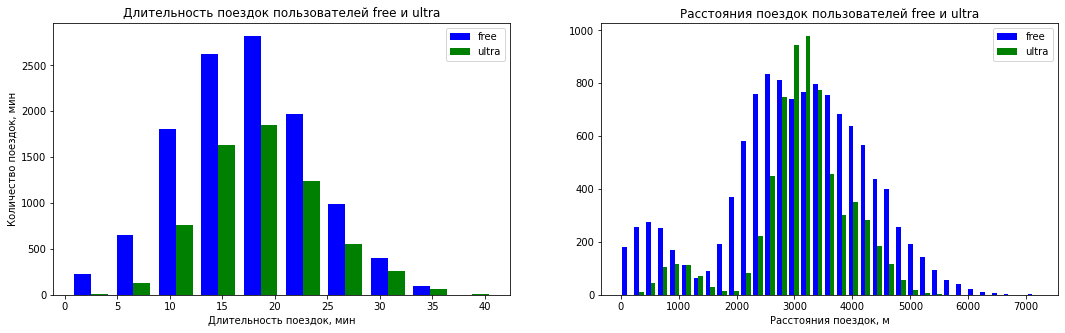

In [46]:
# Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий
free_du = merged_table_free['duration']
ultra_du = merged_table_ultra['duration']    

free_di = merged_table_free['distance']
ultra_di = merged_table_ultra['distance']

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))

colors = ['blue', 'green']
names = ['free', 'ultra']

ax1.hist([free_du, ultra_du], color=colors, label=names);
ax1.set_title('Длительность поездок пользователей free и ultra')
ax1.legend()
ax1.set_xlabel('Длительность поездок, мин')
ax1.set_ylabel('Количество поездок, мин');

ax2.hist([free_di, ultra_di], bins=35, color=colors, label=names);
ax2.set_title("Расстояния поездок пользователей free и ultra")
ax2.set_xlabel('Расстояния поездок, м')
ax2.legend()

plt.show()

Из первой гистограмы видно, что пользователи категории free чаще используют сервис для коротких поездок. С возрастанием длительности поездки эта разница снижается. Количество 35 минутных поездок почти одинаково для обоих категорий. Хотя стоит учесть, что пользователей без подписки в целом больше. Из второй гистограмы видна разница на коротких поездках, пользователи с подпиской реже использую самокаты на короткие поездки до 500 м. и почти не используют на расстояния 2 км. Это отчасти подтверждает версию, что в этой области находятся в основном первые поездки пользователей.

# Вывод:
Мы объединили данные о пользователях, поездках и подписках в один датафрейм. А также, проанализировали информацию отдельно о пользователях с подпиской и без.

# Шаг 5. Подсчёт выручки

In [47]:
# округлим данные в столбцах duration и distance

merged_table['duration'] = np.ceil(merged_table['duration']).astype('int')
merged_table['distance'] = np.ceil(merged_table['distance']).astype('int')

In [48]:
# Создадим датафрейм с агрегированными данными

merged_table_agg = merged_table.groupby(['user_id', 'name', 'age', 'city', 'subscription_type', 'month', 'minute_price', 'start_ride_price', 'subscription_fee']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'name':'count'}).rename(columns={'name':'month_count'}).reset_index()

In [49]:
merged_table_agg.head(5)

,user_id,name,age,city,subscription_type,month,minute_price,start_ride_price,subscription_fee,distance,duration,month_count
0,1,Кира,22,Тюмень,ultra,1,6,0,199,7028,42,2
1,1,Кира,22,Тюмень,ultra,4,6,0,199,755,7,1
2,1,Кира,22,Тюмень,ultra,8,6,0,199,6724,46,2
3,1,Кира,22,Тюмень,ultra,10,6,0,199,5811,32,2
4,1,Кира,22,Тюмень,ultra,11,6,0,199,7005,56,3


In [50]:
# Расчёт месячной выручки

merged_table_agg['month_revenue'] = (
    merged_table_agg['start_ride_price'] * merged_table_agg['month_count'] + 
    merged_table_agg['minute_price'] * merged_table_agg['duration'] + 
    merged_table_agg['subscription_fee']
)

In [51]:
merged_table_agg_pivot = merged_table_agg.groupby(['user_id', 'name', 'age', 'city', 'subscription_type', 'month']).agg({
    'distance': 'sum',
    'duration': 'sum',
    'month_revenue':'sum'}).reset_index()
merged_table_agg_pivot.head(10)

,user_id,name,age,city,subscription_type,month,distance,duration,month_revenue
0,1,Кира,22,Тюмень,ultra,1,7028,42,451
1,1,Кира,22,Тюмень,ultra,4,755,7,241
2,1,Кира,22,Тюмень,ultra,8,6724,46,475
3,1,Кира,22,Тюмень,ultra,10,5811,32,391
4,1,Кира,22,Тюмень,ultra,11,7005,56,535
5,1,Кира,22,Тюмень,ultra,12,6753,28,367
6,2,Станислав,31,Омск,ultra,3,10190,63,577
7,2,Станислав,31,Омск,ultra,4,6165,40,439
8,2,Станислав,31,Омск,ultra,6,3256,14,283
9,2,Станислав,31,Омск,ultra,7,6781,48,487


# Вывод:
Мы собрали агрегированные данные о поездках и посчитали суммарное расстояние, количество поездок и общее время в пути для каждого пользователя в течение каждого месяца. Дополнительно, мы внесли информацию о месячной выручке.

# Шаг 6. Проверка гипотез

###### Гипотеза №1

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Нулевая гипотеза (Н0): среднее время поездок пользователей из двух групп равны.

Альтернативная гипотеза (Н1): среднее время поездок пользователей с подпиской больше, чем среднее время поездок пользователей без подписки.

In [52]:
#Проверим гипотезу

alpha = 0.05 #указываем уровень статистической значимости

results = st.ttest_ind(merged_table_ultra['duration'],
                       merged_table_free['duration'],
                       alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


Пользователи с подпиской тратят за сессию в сервисе больше времени.

###### Гипотеза №2

Расстояние одной поездки в 
3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 
3130 метров? Проверьте гипотезу и сделайте выводы.

Нулевая гипотеза (Н0): среднее расстояние поездки у пользователей с подпиской равно 3130 м

Альтернативная гипотеза (Н1): среднее расстояние поездки у пользователей с подпиской больше 3130 м

In [53]:
#Проверим гипотезу

one_ride = 3130

alpha = 0.05 #указываем уровень статистической значимости

results = st.ttest_1samp(merged_table_ultra['distance'],
                         one_ride,
                         alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает оптимальных 3130 метров.

###### Гипотеза №3

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Нулевая гипотеза (Н0): средняя помесячная выручка от пользователей с подпиской и без - равны.

Альтернативная гипотеза (Н1): средняя помесячная выручка пользователей с подпиской больше, чем среднее значение трат пользователей без подписки.

In [54]:
#Создадим отдельные переменные
ultra_month = merged_table_agg.loc[merged_table_agg.subscription_type == 'ultra', 'month_revenue']
free_month = merged_table_agg.loc[merged_table_agg.subscription_type == 'free', 'month_revenue']

In [55]:
#Проверим гипотезу

alpha = 0.05 #указываем уровень статистической значимости

results = st.ttest_ind(ultra_month,
                       free_month,
                       alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нужно использовать тест о двух зависимых выборках: ttest_rel()

# Общий вывод:
При ознакомлении с данными мы не выявили серьезных отклонений или пропусков в данных.

После поменяли формат данных в столбце date и создали новую колонку с номером месяца поездки. Удалили дубликаты в users, проверили на пропуски.

На основе исследовательского анализа данных мы выявили: 
- Больше всего пользователей в Пятигорске, меньше всего в Москве.
- Пользователей без подписки больше на 8,8% чем пользователей с подпиской.
- Основной возраст пользователей распределен от 20 до 30 лет. Медианное значение возраста пользователей 25 лет.
- Средняя поездка одного пользователся около 3000 метров , чаще всего пользователи проезжают от 2500 до 3500 метров.
- Средняя продолжительность одной поездки 17 минут. Чаще всего продолжительность поездки лежит в диапазоне от 13 до 22 минут.
- Присутствует небольшое количество выбросов в диапазоне 0.5 минут и свыше 33 минут

Объединили данные о пользователях, поездках и подписках в один датафрейм. А также, проанализировали информацию отдельно о пользователях с подпиской и без:
- Пользователи категории free чаще используют сервис для коротких поездок. С возрастанием длительности поездки эта разница снижается. 
- Количество 35 минутных поездок почти одинаково для обоих категорий. Cтоит учесть, что пользователей без подписки в целом больше.
- Пользователи с подпиской реже использую самокаты на короткие поездки до 500 м. и почти не используют на расстояния 2 км. Это отчасти подтверждает версию, что в этой области находятся в основном первые поездки пользователей.

Собрали агрегированные данные о поездках и посчитали суммарное расстояние, количество поездок и общее время в пути для каждого пользователя в течение каждого месяца. Дополнительно, внесли информацию о месячной выручке.

Выводы по гипотезам:
- Гипотеза №1 - пользователи с подпиской тратят за сессию в сервисе больше времени
- Гипотеза №2 - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает оптимальных 3130 метров
- Гипотеза №3 - помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.